# Import necessary modules

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import albumentations as A
from albumentations.pytorch import ToTensorV2 as TTV2
import cv2

import os
import time
import pandas as pd
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

# Install timm to access ViT PyTorch Models

In [2]:
pip install '../input/timm034/timm-0.3.4-py3-none-any.whl'

Processing /kaggle/input/timm034/timm-0.3.4-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


# Import timm

In [3]:
import timm

# Create paths to testing images & pre-trained models

In [4]:
test_path  = '../input/ranzcr-clip-catheter-line-classification/test/'
model_path = '../input/vitbase16384/jx_vit_base_p16_384-83fb41ba.pth'
RANZCR_model_pretrained = '../input/ranzcr-vit384-bcewll-gradalllayers-tp95-epochs26/RANZCR_ViT384_BCEWLL_GradAllLayers_TP95_Epochs26.pt'

# Define ViTBase 16 384 class

In [5]:
class ViTBase_16_384(nn.Module):
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase_16_384, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_384", pretrained=False)
        
        if pretrained:
            self.model.load_state_dict(torch.load(model_path))
            
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)
        
    def forward(self, X):
        X = self.model(X)
        return X

# Create cassava pre-trained ViTBase16 model instance (11 classes)

In [6]:
RANZCR_model = ViTBase_16_384(n_classes=11, pretrained=True)
RANZCR_model.load_state_dict(torch.load(RANZCR_model_pretrained))
RANZCR_gpu_model = RANZCR_model.cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(RANZCR_gpu_model.parameters(), lr=3.50e-04)
RANZCR_gpu_model

ViTBase_16_384(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((76

# Create RANZCRDataset class to load data
# y_label needs 11 values as this is multi-class classification problem

In [7]:
class RANZCRTestDataset(Dataset):
    """RANZCR Test Dataset"""

    def __init__(self, root_dir, test_dir, transform=None):

        super().__init__()
        self.root_dir = root_dir
        self.test_dir = test_dir
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.test_dir))

    def __getitem__(self, idx):
        image_path = self.test_dir + os.listdir(self.test_dir)[idx]
        image_name = os.listdir(self.test_dir)[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
    
        return (image, image_name)

# Define dataset transforms (images to tensors, normalise tensors)

In [8]:
test_transform1 = A.Compose([
           A.Resize(384,384),
           A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
           TTV2()])

test_transform2 = A.Compose([
           A.Resize(384,384),
           A.VerticalFlip(p=1.0),
           A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
           TTV2()])

test_transform3 = A.Compose([
           A.Resize(384,384),
           A.ShiftScaleRotate(p=1.0,border_mode=cv2.BORDER_CONSTANT),
           A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
           TTV2()])

test_transform4 = A.Compose([
           A.Resize(384,384),
           A.Transpose(p=1.0),
           A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
           TTV2()])

 # Create the test datasets (1,2,3)

In [9]:
testset1 = RANZCRTestDataset(root_dir = '' , test_dir=test_path, transform=test_transform1) # Original test image
testset2 = RANZCRTestDataset(root_dir = '' , test_dir=test_path, transform=test_transform2) # Vertical flip
testset3 = RANZCRTestDataset(root_dir = '' , test_dir=test_path, transform=test_transform3) # Random rotations
testset4 = RANZCRTestDataset(root_dir = '' , test_dir=test_path, transform=test_transform4) # Transpose

# Load the test1 dataset

In [10]:
test_batch_size = 16
test1_loader = DataLoader(dataset=testset1, batch_size=test_batch_size, shuffle=False, pin_memory=True, num_workers=2)
test2_loader = DataLoader(dataset=testset2, batch_size=test_batch_size, shuffle=False, pin_memory=True, num_workers=2)
test3_loader = DataLoader(dataset=testset3, batch_size=test_batch_size, shuffle=False, pin_memory=True, num_workers=2)
test4_loader = DataLoader(dataset=testset4, batch_size=test_batch_size, shuffle=False, pin_memory=True, num_workers=2)

# Check to see if test1_loader is working

182106.jpg
714392.jpg
327103.jpg
070009.jpg
464463.jpg
651093.jpg
381281.jpg
537692.jpg
655303.jpg
698686.jpg
130532.jpg
800410.jpg
924183.jpg
764530.jpg
079232.jpg
318568.jpg


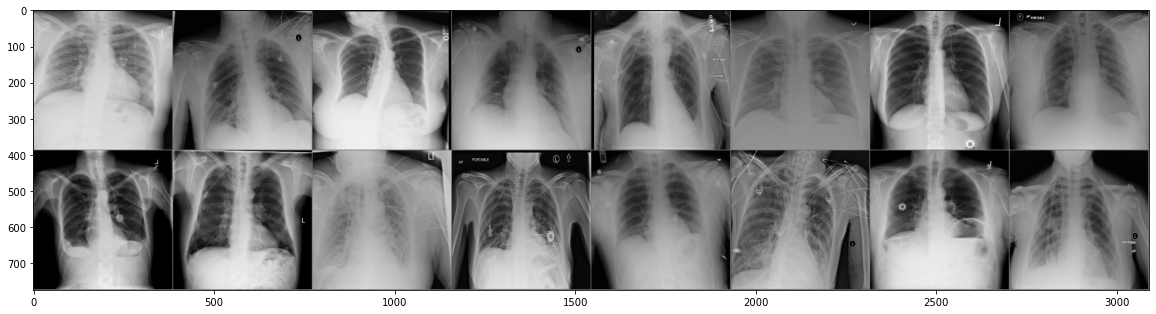

In [11]:
print(test1_loader)

for images,names in test1_loader: 
    break

im = make_grid(images, nrow=8)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225])

im_inv = inv_normalize(im)
for i in range(len(names)):
    print(names[i][-10:])
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Check to see if test2_loader is working

182106.jpg
714392.jpg
327103.jpg
070009.jpg
464463.jpg
651093.jpg
381281.jpg
537692.jpg
655303.jpg
698686.jpg
130532.jpg
800410.jpg
924183.jpg
764530.jpg
079232.jpg
318568.jpg


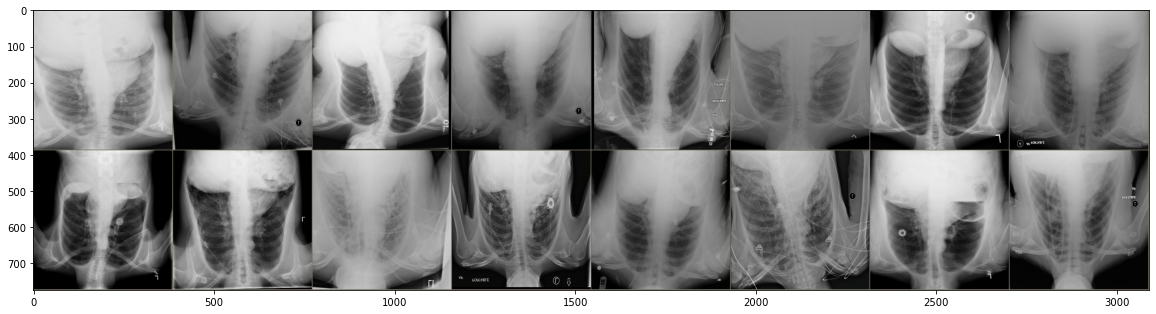

In [12]:
print(test2_loader)

for images,names in test2_loader: 
    break

im = make_grid(images, nrow=8)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225])

im_inv = inv_normalize(im)
for i in range(len(names)):
    print(names[i][-10:])
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Check to see if test3_loader is working

182106.jpg
714392.jpg
327103.jpg
070009.jpg
464463.jpg
651093.jpg
381281.jpg
537692.jpg
655303.jpg
698686.jpg
130532.jpg
800410.jpg
924183.jpg
764530.jpg
079232.jpg
318568.jpg


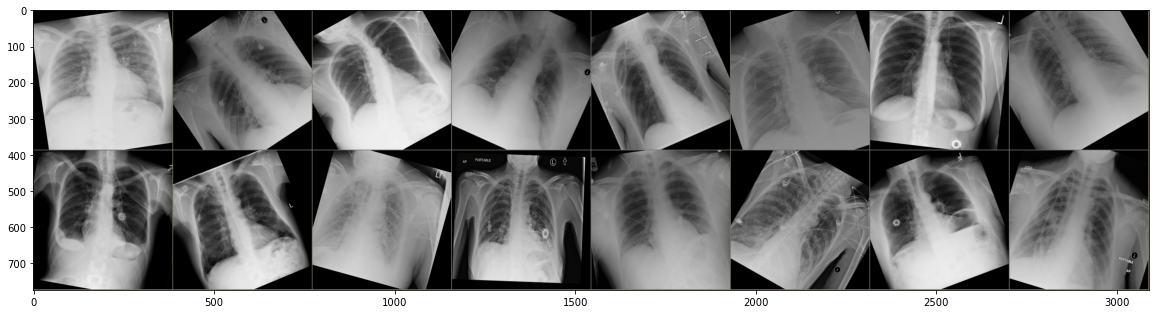

In [13]:
print(test3_loader)

for images,names in test3_loader: 
    break

im = make_grid(images, nrow=8)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225])

im_inv = inv_normalize(im)
for i in range(len(names)):
    print(names[i][-10:])
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Check to see if test4_loader is working

182106.jpg
714392.jpg
327103.jpg
070009.jpg
464463.jpg
651093.jpg
381281.jpg
537692.jpg
655303.jpg
698686.jpg
130532.jpg
800410.jpg
924183.jpg
764530.jpg
079232.jpg
318568.jpg


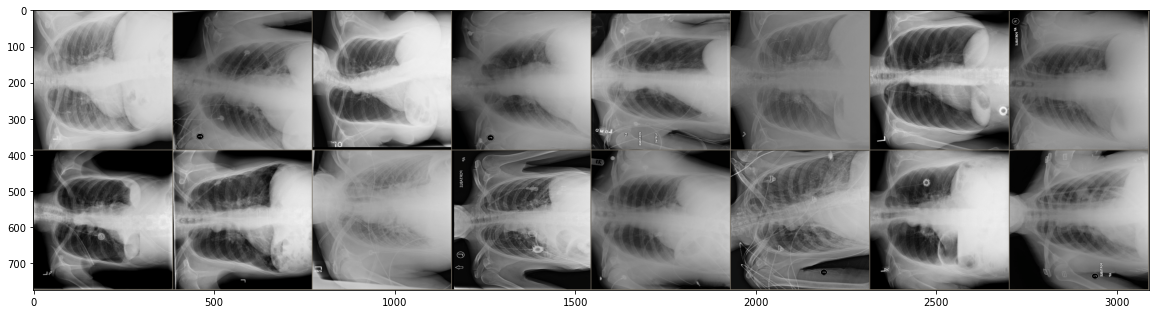

In [14]:
print(test4_loader)

for images,names in test4_loader: 
    break

im = make_grid(images, nrow=8)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225])

im_inv = inv_normalize(im)
for i in range(len(names)):
    print(names[i][-10:])
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Used trained model to generate test data predictions with TTA

In [15]:
col_names = ['ETT - Abnormal',
             'ETT - Borderline',
             'ETT - Normal',
             'NGT - Abnormal',
             'NGT - Borderline',
             'NGT - Incompletely Imaged',
             'NGT - Normal', 'CVC - Abnormal',
             'CVC - Borderline',
             'CVC - Normal','Swan Ganz Catheter Present']

study_inst_col = ['StudyInstanceUID']

# Implementation check parameters

In [16]:
max_test_batch = 100000
print_gap = 100

# Test data predictions 1 (Original image)

In [ ]:
TTA1_df = pd.DataFrame(columns = col_names)
study_inst_df = pd.DataFrame(columns = study_inst_col)
tic = time.time()
with torch.no_grad():
    for b, (X_test, name) in enumerate(test1_loader):
        # Apply the model
        X_test = X_test.cuda()
        y_pred = RANZCR_gpu_model(X_test)             
        predicted = torch.sigmoid(y_pred.data)
        
        if b == max_test_batch:
            break
        b+=1
        
        for i in range(0,len(name)):
            new_row = {'ETT - Abnormal':   float(predicted[i][0]),
                       'ETT - Borderline': float(predicted[i][1]),
                       'ETT - Normal':     float(predicted[i][2]),
                       'NGT - Abnormal':   float(predicted[i][3]),
                       'NGT - Borderline': float(predicted[i][4]),
                       'NGT - Incompletely Imaged':float(predicted[i][5]),
                       'NGT - Normal':     float(predicted[i][6]),
                       'CVC - Abnormal':   float(predicted[i][7]),
                       'CVC - Borderline': float(predicted[i][8]),
                       'CVC - Normal':     float(predicted[i][9]),
                       'Swan Ganz Catheter Present':float(predicted[i][10])}
            TTA1_df = TTA1_df.append(new_row, ignore_index=True)
            study_inst_row = {'StudyInstanceUID': name[i].replace('.jpg','')}
            study_inst_df = study_inst_df.append(study_inst_row, ignore_index=True)

        if b%print_gap==0:
            tac = time.time() - tic
            print('Number of test examples evaluated = ', (b)*len(name), 'Time in minutes = ', tac/60.0)
            
        
toc = time.time() - tic
print('Time for TTA1 is ', toc)
TTA1_df.to_csv('TTA1.csv', index=False)

# Test data predictions 2 (Vertical flip)

In [ ]:
TTA2_df = pd.DataFrame(columns = col_names)
tic = time.time()
with torch.no_grad():
    for b, (X_test, name) in enumerate(test2_loader):
        # Apply the model
        X_test = X_test.cuda()
        y_pred = RANZCR_gpu_model(X_test)
        predicted = torch.sigmoid(y_pred.data)
        
        if b == max_test_batch:
            break
        b+=1
        
        for i in range(0,len(name)):
            new_row = {'ETT - Abnormal':   float(predicted[i][0]),
                       'ETT - Borderline': float(predicted[i][1]),
                       'ETT - Normal':     float(predicted[i][2]),
                       'NGT - Abnormal':   float(predicted[i][3]),
                       'NGT - Borderline': float(predicted[i][4]),
                       'NGT - Incompletely Imaged':float(predicted[i][5]),
                       'NGT - Normal':     float(predicted[i][6]),
                       'CVC - Abnormal':   float(predicted[i][7]),
                       'CVC - Borderline': float(predicted[i][8]),
                       'CVC - Normal':     float(predicted[i][9]),
                       'Swan Ganz Catheter Present':float(predicted[i][10])}
            TTA2_df = TTA2_df.append(new_row, ignore_index=True)

        if b%print_gap==0:
            tac = time.time() - tic
            print('Number of test examples evaluated = ', (b)*len(name), 'Time in minutes = ', tac/60.0)
            
        
toc = time.time() - tic
print('Time for TTA2 is ', toc)
TTA2_df.to_csv('TTA2.csv', index=False)

# Test data predictions 3 (Random rotation)

In [ ]:
TTA3_df = pd.DataFrame(columns = col_names)
tic = time.time()
with torch.no_grad():
    for b, (X_test, name) in enumerate(test3_loader):
        # Apply the model
        X_test = X_test.cuda()
        y_pred = RANZCR_gpu_model(X_test)
        predicted = torch.sigmoid(y_pred.data)
        
        if b == max_test_batch:
            break
        b+=1
        
        for i in range(0,len(name)):
            new_row = {'ETT - Abnormal':   float(predicted[i][0]),
                       'ETT - Borderline': float(predicted[i][1]),
                       'ETT - Normal':     float(predicted[i][2]),
                       'NGT - Abnormal':   float(predicted[i][3]),
                       'NGT - Borderline': float(predicted[i][4]),
                       'NGT - Incompletely Imaged':float(predicted[i][5]),
                       'NGT - Normal':     float(predicted[i][6]),
                       'CVC - Abnormal':   float(predicted[i][7]),
                       'CVC - Borderline': float(predicted[i][8]),
                       'CVC - Normal':     float(predicted[i][9]),
                       'Swan Ganz Catheter Present':float(predicted[i][10])}
            TTA3_df = TTA3_df.append(new_row, ignore_index=True)

        if b%print_gap==0:
            tac = time.time() - tic
            print('Number of test examples evaluated = ', (b)*len(name), 'Time in minutes = ', tac/60.0)
            
        
toc = time.time() - tic
print('Time for TTA3 is ', toc)
TTA3_df.to_csv('TTA3.csv', index=False)

# Test data predictions 4 (Transpose)

In [ ]:
TTA4_df = pd.DataFrame(columns = col_names)
tic = time.time()
with torch.no_grad():
    for b, (X_test, name) in enumerate(test4_loader):
        # Apply the model
        X_test = X_test.cuda()
        y_pred = RANZCR_gpu_model(X_test)
        predicted = torch.sigmoid(y_pred.data)
        
        if b == max_test_batch:
            break
        b+=1
        
        predicted = torch.sigmoid(y_pred.data)
        for i in range(0,len(name)):
            new_row = {'ETT - Abnormal':   float(predicted[i][0]),
                       'ETT - Borderline': float(predicted[i][1]),
                       'ETT - Normal':     float(predicted[i][2]),
                       'NGT - Abnormal':   float(predicted[i][3]),
                       'NGT - Borderline': float(predicted[i][4]),
                       'NGT - Incompletely Imaged':float(predicted[i][5]),
                       'NGT - Normal':     float(predicted[i][6]),
                       'CVC - Abnormal':   float(predicted[i][7]),
                       'CVC - Borderline': float(predicted[i][8]),
                       'CVC - Normal':     float(predicted[i][9]),
                       'Swan Ganz Catheter Present':float(predicted[i][10])}
            TTA4_df = TTA4_df.append(new_row, ignore_index=True)

        if b%print_gap==0:
            tac = time.time() - tic
            print('Number of test examples evaluated = ', (b)*len(name), 'Time in minutes = ', tac/60.0)
            
        
toc = time.time() - tic
print('Time for TTA4 is ', toc)
TTA4_df.to_csv('TTA4.csv', index=False)

# Average predictions from different test augmentation sets

In [ ]:
TTA_pred_df = pd.concat([TTA1_df, TTA2_df, TTA3_df, TTA4_df]).groupby(level=0).mean()
TTA_pred_df.to_csv('TTA_pred_df.csv', index=False)

# Create submission file

In [ ]:
submission_df = study_inst_df.join(TTA_pred_df)
submission_df.to_csv('submission.csv', index=False)